In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Here we consider the multi-armed machines are beta-distribution, with each time the sum of the mean is totalMean.

The beta scheme is the scheme for the person who owns the machine (or opponent), let $n_{i,t}$ be the number of times machine $i$ has been chosen up to time $t-1$. Machine $i$ returns a gain $g_{i,t} = X_{i,t}+Y_{i,t}$, where $X_{i,t}$ has distribution Bernoulli($\frac{i}{2K}$) and ,independently, $Y_{i,t}$ has distribution Beta$(\alpha_{i,t},\beta_{i,t})$  with
$\alpha_{i,t} =\exp{\left(-\frac{K}{t-1}n_{i,t}\right)}$, and $\beta_{i,t} = \sum_{j\ne i}\alpha_{j,t}$
Since Beta$(a,b)$ has mean $\frac{a}{a+b}$, we have, at each time $t$, the mean of the sum of gains by all machines is
$\sum_{i=1}^{K} \mathbb{E}(g_{i,t})=\sum_{i=1}^{K} \mathbb{E}(X_{i,t}) + \mathbb{E}(Y_{i,t})$
Here, we specifically make $\sum_{i=1}^{K} \mathbb{E}(g_{i,t})$ a constant at each time $t$ to ensure that on average, there exists some machine which generate relatively good reward. And $\alpha_{i,t}$ decreases exponentially as $n_{i,t}$ increases, and hence the mean of $Y_{i,t}$ will be small if $n_{i,t}$ is large.

In [3]:
def betaParameters(numPlayed,lamda,totalMean): 
    ##return the beta distribution parameters for each machine according to the times it has been played so far
    alphas = []
    betas = []
    K = len(numPlayed)
    s = 0
    for i in range(K):
        a = np.exp(-numPlayed[i]*lamda)
        s = s+a
        alphas.append(a)
    for i in range(K):
        b = (s - totalMean*alphas[i])*1.0/totalMean
        betas.append(b)
    return alphas,betas

In [5]:
## it returns the mean of each machine
def meansEachMachine(scheme):
    res = []
    for i in range(scheme.K):
        res.append(scheme.alphas[i]/(scheme.alphas[i]+scheme.betas[i])+scheme.bers[i])    
    return res 

In [7]:
class betaScheme:
    def __init__(self,K,totalMean = 1):
        self.K = K
        self.T = 0
        self.totalMean = totalMean
        self.numPlayed = []
        for i in range(self.K):
            self.numPlayed.append(0)
        self.alphas,self.betas = betaParameters(self.numPlayed,0,self.totalMean)
        self.bers = []
        for i in range(self.K):
            self.bers.append((i+1)*1.0/2/K)
    def action(self,j):
        self.numPlayed[j] = self.numPlayed[j]+1
        self.T = self.T+1
        self.alphas,self.betas = betaParameters(self.numPlayed,self.K*1.0/self.T,self.totalMean)
    def getSample(self):
        res = []
        for i in range(self.K):
            temp = np.random.beta(self.alphas[i],self.betas[i])
            if np.random.rand() < self.bers[i]:
                temp += 1
            res.append(temp)
        return res
    def jthSample(self,j):
        temp = np.random.beta(self.alphas[j],self.betas[j])
        if np.random.rand() < self.bers[j]:
            temp += 1
        return temp
    def means(self):
        return meansEachMachine(self)

In [8]:
class MultiArmOpponent: ### the opponent modifies the probability of win if the number of times playing for some
    ### machine increases
    def __init__(self,scheme):
        self.scheme = scheme
        self.K = scheme.K
        self.T = 0
    def getSample(self):
        return self.scheme.getSample()
    def jthSample(self,j):
        return self.scheme.jthSample(j)
    def action(self, j):
        self.scheme.action(j)
        self.T = self.T+1

In [9]:
### for the player, compute the probability for choosing each machine
def categoryProbability(ita,gains):
    K = len(gains)
    res = []
    s = 0
    for i in range(K):
        p = np.exp(ita*gains[i])
        s = s+p
        res.append(p)
    for i in range(K):
        res[i] = res[i]*1.0/s
    return res

# FULL INFORMATION GAME

In [10]:
class FullInformationGame:   ### the strategy you take to beat opponent if you know full information
    def __init__(self,ita,MAOmodel):
        self.myMAOmodel = MAOmodel
        self.K = MAOmodel.K
        self.ita = ita
        self.T =0
        self.gains = []
        self.maxiGain = 0
        for i in range(self.K):
            self.gains.append(0)
        self.categProb = categoryProbability(self.ita,self.gains)
        self.acturalGain = 0
    def play(self):
        j = np.random.choice(self.K,1,p=self.categProb)[0]
        curgains = self.myMAOmodel.getSample()
        self.acturalGain = self.acturalGain + curgains[j]
        self.T = self.T+1
        self.myMAOmodel.action(j)
        self.maxiGain = 0
        for i in range(self.K):
            self.gains[i] = self.gains[i]+curgains[i]
            if self.maxiGain < self.gains[i]:
                self.maxiGain = self.gains[i]
        self.categProb = categoryProbability(self.ita,self.gains)

In [11]:
def betaFIGmean(K,T,R):  ## find the mean of regret (difference of maxiGain and acturalGain) for different number 
    ## of trials, each T, runs for R times, which enable us to find the average
    print "we are doing for T = "+str(T)
    ita = np.log(1+np.sqrt(2*np.log(K)/T))
    res = 0
    for i in range(R):
        scheme = betaScheme(K)
        myMAO = MultiArmOpponent(scheme)
        myFIG = FullInformationGame(ita,myMAO)
        for i in range(T):
            myFIG.play()
        res = res+(myFIG.maxiGain-myFIG.acturalGain)
    res = res/R
    return res

# PARTIAL INFORMATION GAME

In [12]:
def hatCategoryProbability(ita,gamma,gains):
    res = categoryProbability(ita,gains)
    for i in range(len(res)):
        res[i] = (1-gamma)*res[i]+gamma*1.0/len(gains)
    return res

In [13]:
class PartialInformationGame:   ### the strategy you take to beat opponent if you know partial information
    def __init__(self,ita,gamma,ki,MAOmodel):
        self.myMAOmodel = MAOmodel
        self.K = MAOmodel.K
        self.gamma = gamma
        self.ita = ita
        self.ki = ki
        self.T =0
        self.gains = []
        self.eachSum = [0]*self.K
        self.maxiSum = 0
        for i in range(self.K):
            self.gains.append(0)
        self.categProb = hatCategoryProbability(self.ita,self.gamma,self.gains)
        self.acturalGain = 0
    def play(self):
        j = np.random.choice(self.K,1,p=self.categProb)[0]
        #print "j is " + str(j)
        temp = self.myMAOmodel.scheme.getSample()
        curgain = temp[j]
        self.acturalGain = self.acturalGain + curgain
        #print "actural gain is "+str(curgain)
        self.T = self.T+1
        self.myMAOmodel.action(j)
        for i in range(self.K):
            if i == j:
                self.gains[i] = self.gains[i] + (curgain+self.ki)*1.0/self.categProb[i]
            else:
                self.gains[i] = self.gains[i] + (self.ki)*1.0/self.categProb[i]
        self.categProb = hatCategoryProbability(self.ita,self.gamma,self.gains)
        for i in range(self.K):
            self.eachSum[i] += temp[i]
            if self.eachSum[i] > self.maxiSum:
                self.maxiSum = self.eachSum[i]
        return j,curgain

In [15]:
## for different T, compute the mean of regret by doing R times for Exp3.P strategy
def betaPIGmean(K,T,R):
    #print "we are doing for T = "+str(T)
    gamma = np.sqrt(K*np.log(K)/(np.exp(1)-1)/T)
    if gamma > 1:
        gamma =1
    ita = gamma/K
    ki = 0
    res = 0
    for i in range(R):
        scheme = betaScheme(K)
        myMAO = MultiArmOpponent(scheme)
        myPIG = PartialInformationGame(ita,gamma,ki,myMAO)
        for i in range(T):
            myPIG.play()
        res = res+(myPIG.maxiSum-myPIG.acturalGain)
    res = res/R
    return res

In [322]:
### for T = 1,6,11,...1001, compute the mean
diff = []
for t in np.arange(1,1002,5):
    if t % 100 == 1:
        print t
    diff.append(betaPIGmean(5,t,100))

1
101
201
301
401
501
601
701
801
901
1001


## If we use random strategy to choose the arm

In [323]:
class RandomGame:   ### the strategy you take to beat opponent if you know partial information
                                ### we know the upper bound of EG_max
    def __init__(self,MAOmodel):
        self.myMAOmodel = MAOmodel
        self.K = MAOmodel.K
        self.T =0
        self.eachSum = [0]*self.K
        self.maxiSum = 0
        self.categProb = []
        for i in range(self.K):
            self.categProb.append(1.0/self.K)
        self.acturalGain = 0
    def play(self):
        j = np.random.choice(self.K,1,p=self.categProb)[0]
        #print "j is " + str(j)
        temp = self.myMAOmodel.scheme.getSample()
        curgain = temp[j]
        self.acturalGain = self.acturalGain + curgain
        #print "actural gain is "+str(curgain)
        self.T = self.T+1
        self.myMAOmodel.action(j)
        for i in range(self.K):
            self.eachSum[i] += temp[i]
            if self.eachSum[i] > self.maxiSum:
                self.maxiSum = self.eachSum[i]
        return j,curgain

In [324]:
def betaRandommean(K,T,R):
    #print "we are doing for T = "+str(T)
    res = 0
    for i in range(R):
        scheme = betaScheme(K)
        myMAO = MultiArmOpponent(scheme)
        myGame = RandomGame(myMAO)
        for i in range(T):
            myGame.play()
        res = res+(myGame.maxiSum-myGame.acturalGain)
    res = res/R
    return res

In [325]:
rdiff = []
for t in np.arange(1,1002,5):
    if t % 100 == 1:
        print t
    rdiff.append(betaRandommean(5,t,100))

1
101
201
301
401
501
601
701
801
901
1001


In [79]:
## theoretical upper bound of regret
A = np.arange(0,1020,0.5)
b = []
for a in A:
    b.append(2.63*np.sqrt(2*a*5*np.log(5)))

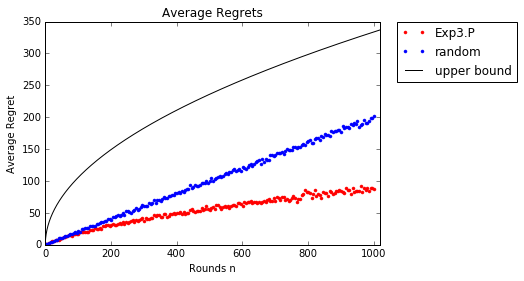

In [80]:
### plot the regret by EX3.P AND RANDOM
f = plt.subplot(111)
f.plot(np.arange(1,1002,5),diff,'.',color='red',label = 'Exp3.P')
f.plot(np.arange(1,1002,5),rdiff,'.',color='blue',label = 'random')
f.plot(A,b,'-',color = 'black',label = 'upper bound')
f.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.set_xlim([0,1020])
plt.xlabel('Rounds n')
plt.ylabel('Average Regret')
plt.title("Average Regrets")
plt.show()

## MATRIX REPEATED GAME

the game is defined by a $m \times n$ matrix $M$ such that each entry $M_{i j} \in [0, 1]$. At each time $t$, the row player chooses a row $i$ and the opponent(column player) chooses a column $j$. The row player then received the payoff $M_{i j}$. The row player's goal is to maximize its expected total payoff over a sequence of plays.


Suppose, at time $t$, the row player chooses the row randomly according to a probability distribution $p = (p_1, \ldots, p_m)^T$, and the column player similarly chooses the column according to a distribution $q=(q_1, \ldots, q_n)^T$. Then row player's expected payoff is $p^T M q$.


The value of the game is $\max_p\min_q\ {p}^T M q$, and can be computed using linear programming.

In [22]:
import scipy.optimize as op

In [23]:
class RepeatedGame:
    def __init__(self,a,b,m,n):  ## m*n matrix each entry between a and b
        self.lower = a
        self.upper = b
        self.M = np.random.rand(m,n)
        self.M = a + (b-a)*self.M
        self.m = self.M.shape[0]
        self.n = self.M.shape[1]
        ##solve the linear programming to get Nash equi and optimal strategy
        c = []
        bound = []
        rc = []
        rbound = []
        rb =[]
        for i in range(self.n):
            c.append(-1)
            bound.append((0,None))
            rb.append(-1)
        b = []
        for i in range(self.m):
            b.append(1)
            rc.append(1)
            rbound.append((0,None))
        self.sol = op.linprog(c,A_ub = self.M, b_ub = b, bounds = bound)
        self.rsol = op.linprog(rc,A_ub = -1*self.M.transpose(),b_ub = rb, bounds = rbound)
        self.equi = -1.0/self.sol['fun']
        self.colDist = self.equi*self.sol['x']
        self.rowDist = 1.0/self.rsol['fun']*self.rsol['x']
    def getReward(self,i,j):
        return (self.M[i,j]-self.lower)*1.0/(self.upper-self.lower)
        

Suppose, the matrix $M$ is entirely unknown to the row player. Moreover, in each play of the game, the row player only knows the value $M_{ij}$, the actual gain of this play. What makes things even worse is that, not only does the column player know the entire matrix $M$, but it also knows, at each time $t$, the row player's strategy $p_t$ before choosing its own strategy. So the column player
can choose the column argmin$_{j}\sum_{i=1}^{K}M_{ij}p^{(t)}_i$ with probability 1. 

Next, we will design this strategy for the column player (opponent).

In [25]:
class RiggedRepeatedGame:  ## here the adversary only knows the entire matrix, but also know your strategy.
    def __init__(self,ita,gamma, RGmodel):
        self.RGmodel = RGmodel
        self.m = RGmodel.m
        self.n = RGmodel.n
        self.gamma = gamma
        self.ita = ita
        self.T =0
        self.gains = []
        for i in range(self.m):
            self.gains.append(0)
        self.categProb = hatCategoryProbability(self.ita,self.gamma,self.gains)
        self.acturalGain = 0
        self.rowChoices = []
        self.colChoices = []
    def columnStrategy(self):
        return np.argmin(np.dot(self.categProb,self.RGmodel.M))
    def play(self):
        i = np.random.choice(self.m,1,p=self.categProb)[0]
        j = self.columnStrategy()
        self.rowChoices.append(i)
        self.colChoices.append(j)
        curgain = self.RGmodel.getReward(i,j)
        #print curgain
        self.acturalGain = self.acturalGain + curgain
        self.T = self.T+1
        self.gains[i] = self.gains[i] + curgain*1.0/self.categProb[i]
        self.categProb = hatCategoryProbability(self.ita,self.gamma,self.gains)
    def rowGain(self):
        return self.acturalGain*(self.RGmodel.upper-self.RGmodel.lower)+self.RGmodel.lower

This is an example of this repeated game, when number of rows and number of columns are both 10, each element is between 0 and 100

In [84]:
RGmodel = pickle.load(open('myRGmodel.obj','rb'))

In [27]:
gamma = np.sqrt(10*np.log(10)/(np.exp(1)-1)/2000)

In [28]:
ita = gamma/10

### playing the this game for 2000 times

In [101]:
RRG = RiggedRepeatedGame(ita,gamma,RGmodel)
for j in range(2000):
    RRG.play()

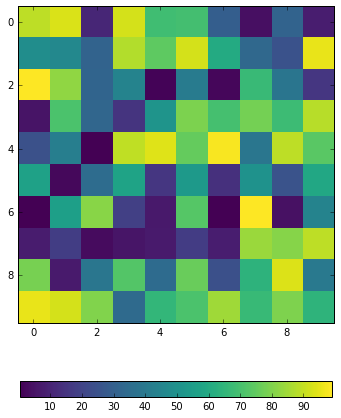

In [86]:
fig,ax = plt.subplots(figsize=(7,7))
ax.set_frame_on(True)
ax.set_aspect('equal')
plt.imshow(RGmodel.M, interpolation='nearest', cmap=plt.cm.viridis)
#plt.title("Payoff Matrix")
plt.colorbar(orientation="horizontal",fraction=0.04)
plt.show()

In [85]:
print "the average best for row players is "+str(RGmodel.equi)

the average best for row players is 57.6397722283


In [102]:
masked = np.zeros((10,10))
for i in range(1000):
    masked[RRG.rowChoices[i],RRG.colChoices[i]] += 1
    A = np.ma.masked_where(masked == 0,masked)

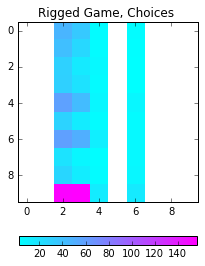

the gain per round is: 50.5330331595


In [103]:
fig,ax = plt.subplots()
ax.set_aspect('equal')
ax.set_frame_on(True)
plt.imshow(A, interpolation='nearest', cmap=plt.cm.cool)
plt.colorbar(orientation="horizontal",fraction=0.04)
plt.title("Rigged Game, Choices ")
plt.show()
print "the gain per round is: "+str( RRG.rowGain()/2000)

## doing analysis for different games for different rows and columns, and different number of plays for each game

In [73]:
def RRGmean(RGmodel,T,rounds):
    gain = 0
    gamma = np.sqrt(RGmodel.m*np.log(RGmodel.m)/(np.exp(1)-1)/T)
    if gamma > 1:
        gamma =1
    ita = gamma/10
    for i in range(rounds):
        ##print "playing for the "+str(i)+"th round"
        RRG= RiggedRepeatedGame(ita,gamma,RGmodel)
        for j in range(T):
            RRG.play()
        a = RRG.rowGain()*1.0/T
        gain = gain+a
    return gain*1.0/rounds    
    

In [108]:

def RRGAnalysis(rounds,RGmodel):
    print "the best possible average gain for row players is " + str(RGmodel.equi)
    avePerGain = []
    for t in np.arange(1,10001,50):
        print "this is for T = "+str(t)
        a = RRGmean(RGmodel,t,rounds)
        print a
        avePerGain.append(a)
    return avePerGain
        

In [70]:
## for a 10*10 matrix
RGmodel = RepeatedGame(0,100,10,10)

In [17]:
avePerGain = RRGAnalysis(50,RGmodel);

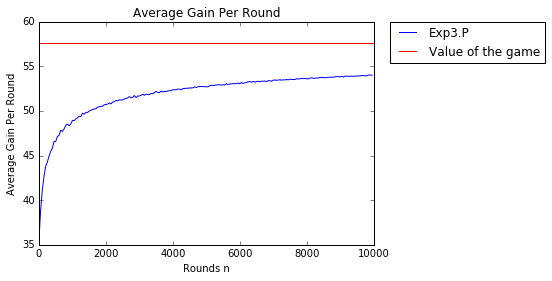

In [98]:
fig = plt.subplot(111)
fig.plot(np.arange(1,10001,50),avePerGain,color = 'blue',label = 'Exp3.P')
plt.xlabel('Rounds n')
plt.ylabel('Average Gain Per Round')
plt.axhline(y=RGmodel.equi, xmin=0, xmax=1, hold=None,color = 'red',label = 'Value of the game')
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Average Gain Per Round")
fig.set_xlim([0,10003])
plt.show()